In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW-NB15/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW-NB15/test.csv')
print(test_raw.shape)

# Seperate label and Drop
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
test_Y = test_raw['label']

# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

(82332, 45)
(175341, 45)


In [4]:
features_lr = ['sttl', 'smean']
features_gb = ['sttl','smean','sload','ct_state_ttl','rate','dur','dload','dmean','sinpkt','dpkts']
features_nn = ['sttl','smean','sload','ct_state_ttl','rate','dur','dload','dmean','sinpkt']

In [ ]:
# hyperparameters to search
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter = [100, 300, 500, 1000, 5000, 10000]
grid = dict(solver=solvers, C=c_values, max_iter=max_iter, random_state=[0], n_jobs=[-1])
# grid search
model_lr = LogisticRegression()
cv = RepeatedStratifiedKFold(random_state=0)
grid_search = GridSearchCV(estimator=model_lr, param_grid=grid, scoring='f1', cv=cv, n_jobs=-1, error_score=0)
grid_result = grid_search.fit(train_X1, train_Y)
# get the best result
print("Best: %f using %s with all features" % (grid_result.best_score_, grid_result.best_params_))
grid_result = grid_search.fit(train_X1[features_lr], train_Y)
# get the best result
print("Best: %f using %s with selected features" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.888554 using {'C': 100, 'max_iter': 100, 'n_jobs': -1, 'random_state': 0, 'solver': 'newton-cg'} with all features
Best: 0.785163 using {'C': 0.01, 'max_iter': 100, 'n_jobs': -1, 'random_state': 0, 'solver': 'newton-cg'} with selected features


In [53]:
model_lr = LogisticRegression(solver='newton-cg', C=100, max_iter=100, n_jobs=-1, random_state=0)
model_lr.fit(train_X1[features_lr], train_Y)
predict = model_lr.predict(test_X1[features_lr])
print(f1_score(test_Y, predict))

0.8844358059762062


In [54]:
model_lr = LogisticRegression(solver='newton-cg', C=0.01, max_iter=100, n_jobs=-1, random_state=0)
model_lr.fit(train_X1[features_lr], train_Y)
predict = model_lr.predict(test_X1[features_lr])
print(f1_score(test_Y, predict))

0.884446323991132


In [13]:
# hyperparameters to search
n_estimators = [1000, 3000, 5000, 10000]
learning_rate = [0.01, 0.1]
subsample = [0.7, 0.8, 0.9, 1.0]
max_depth = [7, 9, 11]
grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, max_depth=max_depth)

model_gb = GradientBoostingClassifier(random_state=0)
grid_search = GridSearchCV(estimator=model_gb, param_grid=grid, scoring='f1', cv=cv, n_jobs=-1, error_score=0)
grid_result = grid_search.fit(train_X1, train_Y)
# get the best result
print("Best: %f using %s with all features" % (grid_result.best_score_, grid_result.best_params_))
grid_result = grid_search.fit(train_X1[features_lr], train_Y)
# get the best result
print("Best: %f using %s with selected features" % (grid_result.best_score_, grid_result.best_params_))
unpatch_sklearn()

Best: 0.982637 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 1.0} with all features
Best: 0.906246 using {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.7} with selected features


In [50]:
patch_sklearn()
model_gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=1.0, random_state=0)
model_gb.fit(train_X1[features_gb], train_Y)
predict = model_gb.predict(test_X1[features_gb])
print(f1_score(test_Y, predict))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


0.9270278845136956


In [51]:
model_gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7, random_state=0)
model_gb.fit(train_X1, train_Y)
predict = model_gb.predict(test_X1)
print(f1_score(test_Y, predict))

0.9210996360510871


In [14]:
from tensorflow.python.keras import Sequential, layers, optimizers, losses, metrics, callbacks, backend

In [15]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [38]:
# early stopping to prevent overfitting
callback = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, min_delta=0.001, restore_best_weights=True)
# model training
model_nn = ModelCreate((len(features_nn),))
history = model_nn.fit(train_X1[features_nn], train_Y, validation_split=0.2, epochs=1000, use_multiprocessing=True, verbose=0)

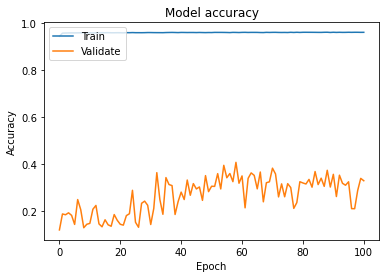

In [39]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

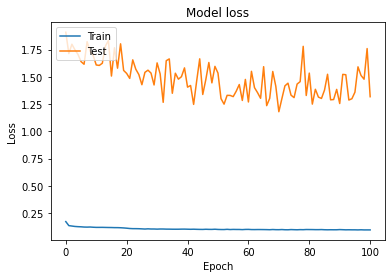

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:
predicts = model_nn.predict(test_X1[features_nn])
predicts = np.where(predicts < 0.5, 0, 1)
print(f1_score(test_Y, predicts))

0.9491819857438792


In [43]:
# model training
model_nn = ModelCreate((train_X1.shape[1],))
history = model_nn.fit(train_X1, train_Y, validation_split=0.2, epochs=1000, callbacks=[callback], use_multiprocessing=True, verbose=0)

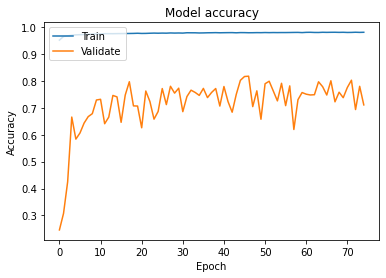

In [44]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

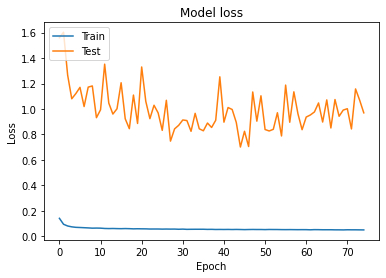

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [46]:
predicts = model_nn.predict(test_X1)
predicts = np.where(predicts < 0.5, 0, 1)
print(f1_score(test_Y, predicts))

0.9316157649286442
